# Estimate Sobol' indices for the Ishigami function by a sampling method: a quick start guide to sensitivity analysis

In this example, we estimate the Sobol' indices for the Ishigami function by sampling methods. 

Let $a=7$ and $b=0.1$. We consider the function 

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

for any $X_1,X_2,X_3\in[-\pi,\pi]$ 

We assume that the random variables $X_1,X_2,X_3$ are independent and identically distributed according to the uniform distribution on the interval $[-\pi, \pi]$:

$$
X_1,X_2,X_3\sim \mathcal{U}(-\pi,\pi).
$$

## Introduction

In this example we are going to quantify the correlation between the input variables and the output variable of a model thanks to Sobol indices.

Sobol indices are designed to evaluate the importance of a single variable or a specific set of variables. Here the Sobol indices are estimated by sampling from the distributions of the input variables and propagating uncertainty through a function.

In theory, Sobol indices range from 0 to 1; the closer an index value is to 1, the better the associated input variable explains the function output. 

Let us denote by $d$ the input dimension of the model. 

Sobol' indices can be computed at different orders.

* First order indices evaluate the importance of one input variable at a time.

* Total indices give the relative importance of one input variable and all its interactions with other variables. Alternatively, they can be viewed as measuring how much wriggle room remains to the output when all but one input variables are fixed.

* In general, we are only interested in first order and total Sobol' indices. There are situations, however, where we want to estimate interactions. Second order indices evaluate the importance of every pair of input variables. The number of second order indices is:

$$
\binom{d}{2} = \frac{d \times \left( d-1\right)}{2}.
$$ 

In practice, when the number of input variables is not small (say, when $d>5$), then the number of second order indices is too large to be easily analyzed. In these situations, we limit the analysis to the first order and total Sobol' indices.

## Define the model

In [1]:
import openturns as ot
import numpy as np
import pylab as pl
import openturns.viewer

Create the Ishigami test function.

In [2]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

Create the probabilistic model

In [3]:
inputDimension = 3
distributionList = [ot.Uniform(-np.pi, np.pi)] * inputDimension
distribution = ot.ComposedDistribution(distributionList)

## Draw the function

In [4]:
n = 10000
sampleX = distribution.getSample(n)
sampleY = g(sampleX)

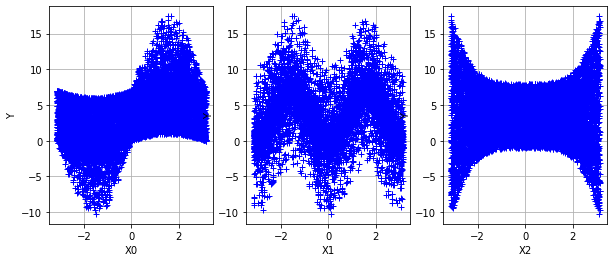

In [5]:
def plotXvsY(sampleX, sampleY, figsize=(15,3)):
    dimX = sampleX.getDimension()
    inputdescr = sampleX.getDescription()
    fig = pl.figure(figsize=figsize)
    for i in range(dimX):
        ax = fig.add_subplot(1, dimX, i+1)
        graph = ot.Graph('', inputdescr[i], 'Y', True, '')
        cloud = ot.Cloud(sampleX[:,i],sampleY)
        graph.add(cloud)
        _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    return fig

plotXvsY(sampleX, sampleY, figsize=(10,4));

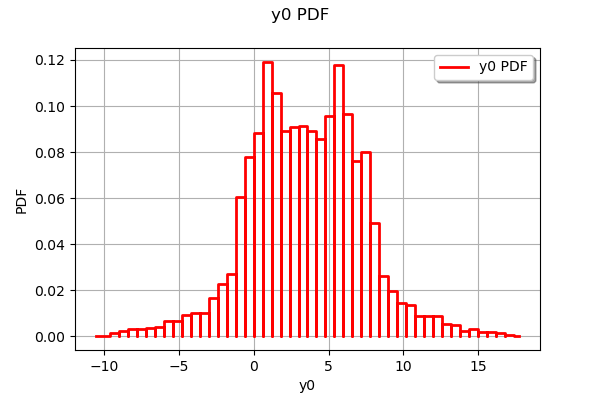

In [6]:
ot.HistogramFactory().build(sampleY).drawPDF()

We see that the distribution of the output has two modes. 

## Estimate the Sobol' indices

We first create a design of experiments with the `SobolIndicesExperiment`. Since we are not interested in second order indices for the moment, we use the default value of the third argument (we will come back to this topic later).

In [7]:
size = 1000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
inputDesign.setDescription(input_names)
inputDesign.getSize()

5000

We see that 5000 function evaluations are required to estimate the first order and total Sobol' indices.

Then we evaluate the outputs corresponding to this design of experiments.

In [8]:
outputDesign = g(inputDesign)

Then we estimate the Sobol' indices with the `SaltelliSensitivityAlgorithm`. 

In [9]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

The `getFirstOrderIndices` and `getTotalOrderIndices` method respectively return estimates of all first order and total Sobol' indices.

In [10]:
sensitivityAnalysis.getFirstOrderIndices()

class=Point name=Unnamed dimension=3 values=[0.334197,0.42868,-0.0246479]

In [11]:
sensitivityAnalysis.getTotalOrderIndices()

class=Point name=Unnamed dimension=3 values=[0.538721,0.440278,0.2622]

The `draw` method produces the following graph. The vertical bars represent the 95% confidence intervals of the estimates. 

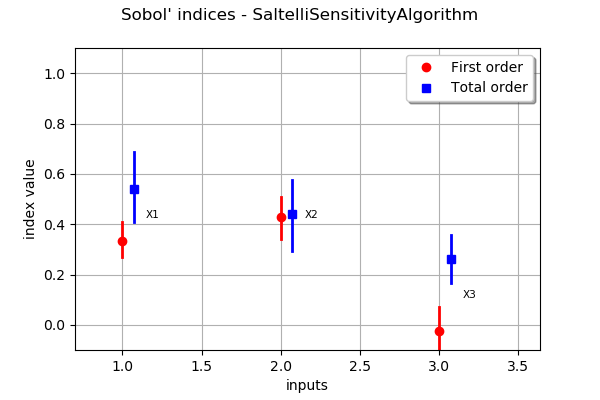

In [12]:
graph = sensitivityAnalysis.draw()
graph

- We see that the variable $X_1$, with a total Sobol' index close to 0.6, is the most significant variable, taking into account both its direct effect and its interactions with other variables. Its first order index is close to 0.3, which implies that its interactions alone produce almost 30% (0.6 - 0.3) of the total variance.
- The variable $X_2$ has the highest first order index: approximately 0.4. However, it has little interaction with other variables since its total order indice is close to its first order index.
- The variable $X_3$ has a first order index close to zero. However, it has an impact to the total variance thanks to its interactions with $X_1$. 
- We see that the variability of the estimates is quite high even with a relatively large sample size. Moreover, since the exact first order Sobol' index for $X_3$ is zero, its estimate has a 50% chance of being nonpositive. 

## Estimate the second order indices

In [13]:
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(distribution, size, computeSecondOrder)
inputDesign = sie.generate()
print(inputDesign.getSize())
inputDesign.setDescription(input_names)
outputDesign = g(inputDesign)

8000


We see that 8000 function evaluations are now required; that is 3000 more evaluations than in the previous situation.

In [14]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [15]:
second_order = sensitivityAnalysis.getSecondOrderIndices()
for i in range(inputDimension):
    for j in range(i):
        print('2nd order indice (%d,%d)=%g' % (i,j,second_order[i,j]))

2nd order indice (1,0)=-0.0805798
2nd order indice (2,0)=0.0914596
2nd order indice (2,1)=-0.0988192


This shows that the only significant interaction is the one between $X_1$ and $X_3$ (beware of Python's index shift: 0 denotes the first input variable).

## Using a different estimator

We have used the `SaltelliSensitivityAlgorithm` class to estimate the indices. Others are available in the library:
* `MartinezSensitivityAlgorithm`
* `JansenSensitivityAlgorithm`
* `MauntzKucherenkoSensitivityAlgorithm`


In order to compare the results with another method, we use the `MartinezSensitivityAlgorithm` class.

In [16]:
sensitivityAnalysis = ot.MartinezSensitivityAlgorithm(inputDesign, outputDesign, size)

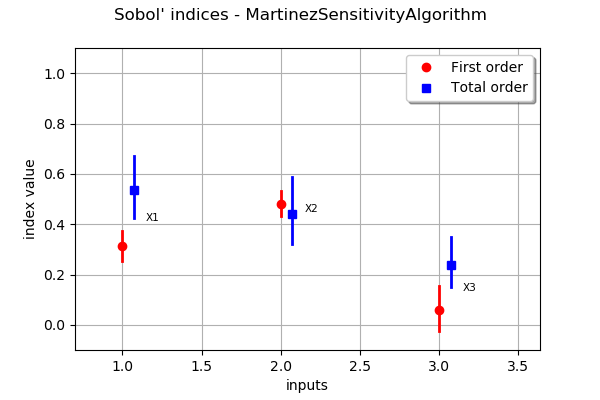

In [17]:
graph = sensitivityAnalysis.draw()
graph

We see that the results do not change significantly in this particular situation.